In [ ]:
# 필요한 라이브러리를 호출하기

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

# 파이토치 Device 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 이미지 Dataset을 전처리해주는 Class를 제작
# trainset data, validation data 각각 다음과 같이 Data Augmentation 실시

class ImageTransform:
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
        ]),
        'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),    
                transforms.Normalize(mean,std)
        ])
    }

  def __call__(self, img, phase):
    return self.data_transform[phase](img)

In [ ]:
# 이미지 데이터셋을 불러온 후 훈련, 검증, 테스트 세트로 분리한다

# Cat 디렉토리에 고양이 사진들이, Dog 디렉토리에 강아지 사진들이 있다.
# 이 사진들을 train_data, val_data, test_data 세트들로 분류하는 코드이다.

cat_directory = r"./Cat"
dog_directory = r"./Dog"

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]


In [ ]:
# 여러 개의 이미지들을 받아서 한 줄에 5개의 이미지를 출력하는 용도의 함수 제작
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12,6))
  for i, image_filepath in enumerate(images_filepaths):
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # cv로 읽어들인 데이터는 BGR형식으로 되어 있다.
    # 이것을 파이토치에서 활용하기 위해 RGB 형식으로 바꾼다.
    # pre-trained model역시 RGB형식으로 된 이미지로 훈련된 모델이기 때문이다.

    true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
    #이미지 파일에서 cat 또는 dog를 분리해낸다
    predicted_label = predicted_labels[i] if predicted_labels else true_label
    color = "green" if true_label == predicted_label else "red"
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(predicted_label, color=color)
    ax.ravel()[i].set_axis_off()
  plt.tight_layout()
  plt.show()


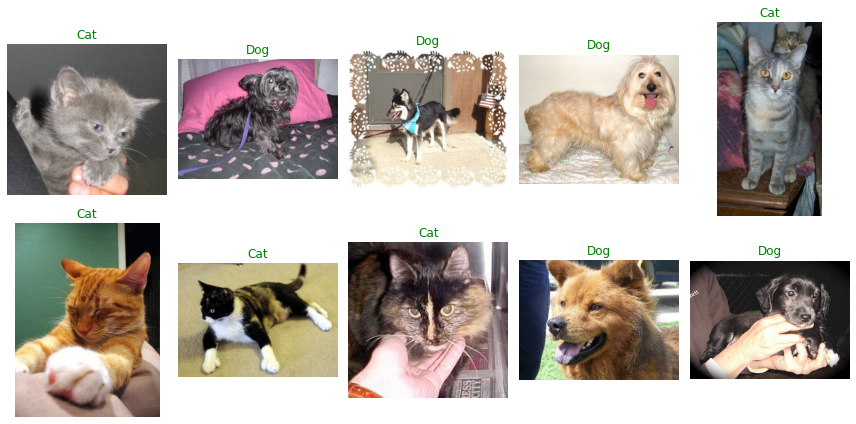

In [ ]:
display_image_grid(test_images_filepaths)

In [ ]:
# 이미지를 불러오기 위한 CustomDataset을 제작할 것이다
# CustomDataset에서는 반드시 __init__, __len__, __getitem__메서드가 overriding되어 있어야 하며
# 생성된 dataset 객체를 가지고 DataLoader를 생성할 것이다

class DogvsCatDataset(Dataset):
  def __init__(self, file_list, transform=None, phase="train"):
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, idx):
    img_path = self.file_list[idx]
    img = Image.open(img_path)
    img_transformed = self.transform(img, self.phase)
    label = img_path.split("/")[-1].split(".")[0]
    # ./Dog/dog.113.jpg라는 파일이 있다고 하자
    # 파일명의 dog를 추출하여 label로 사용하려는 것이다
    if label == "dog":
      label = 1
    elif label == "cat":
      label = 0
    return img_transformed, label


In [ ]:
# 전처리에서 사용할 변수에 대한 값을 정의
size = 224

# 파이토치의 pre-trained model은 대부분 ImageNet의 이미지 데이터를 통하여 훈련되었다.
# 이 이미지의 RGB평균과 표준편차로 데이터를 정규화하는 과정을 통해야만
# pre-trained model이 정상적으로 작동할 수 있다.
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

batch_size = 32

In [ ]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean,std), phase = "train")
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean,std), phase='val')

index = 0

In [ ]:
# 데이터를 불러오기 위한 DataLoader를 정의한다

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}


In [ ]:
# LeNet 모델 네트워크본격적으로 구현하기

class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    
    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(32*53*53, 512)
    self.relu5 = nn.ReLU()
    self.fc2 = nn.Linear(512,2)
    self.output = nn.Softmax(dim=1)

  def forward(self, x):
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)
    out = out.view(out.size(0), -1)
    # out의 형태는(batch_size, 높이, 너비)형태이다
    # 이것을 배치별로 펼치게 하기 위하여 위와 같은 코드를 작성하였다.
    
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.output(out)
    return out

In [ ]:
# 모델을 생성하고 학습을 준비하기

model = LeNet()


In [ ]:
# torchsummary의 summary메소드를 이용하여
# 어떠한 형상의 input이 들어갔을 때 각 층에서 출력되는 값이 어떠할 것인지
# 한 눈에 알아볼 수 있도록 해주는 기능을 사용할 것이다

from torchsummary import summary
summary(model, input_size=(3,224,224))

In [ ]:
# 모델에서 총 몇 개의 학습 가능한 parameters가 존재할까 확인해보기

# model.parameters()는
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

46038242


In [ ]:
for p in model.parameters():
  print(p.numel())

1200
16
12800
32
46022656
512
1024
2


In [ ]:
# optimizer와 loss_function정의하기
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# default로 reduction="mean"이 파라미터로 입력된다
# 매 에폭마다 CEE를 산출할 때 모든 데이터의 CEE의 합이 반환된다.

In [ ]:
# 모델의 파라미터와 손실함수를 cpu 또는 gpu에 할당하기

model = model.to(device)
criterion = criterion.to(device)


In [ ]:
# 모델 학습 함수 정의하기
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
  since = time.time()
  best_acc = 0.0

  for epoch in range(num_epoch):
    print("Epoch {} / {}".format(epoch+1, num_epoch))
    print("-"*20)

    # 한 번의 Epoch당 학습과 평가를 동시에 시행한다
    for phase in ['train','val']:
      if phase == "train":
        model.train() # Training Mode
      else:
        model.eval() # Evaluation Mode

      epoch_loss = 0.0 # 한 에폭에서 발생한 총 손실함수값을 구한다
      epoch_corrects = 0 # 에폭 당 validation을 시행할 때 몇 개의 데이터를 맞추는지를 카운팅하기

      for inputs, labels in tqdm(dataloader_dict[phase]):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Train mode일 때만 기울기값을 계산하여 자원과 시간소모를 줄인다
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(inputs)
          preds = torch.max(outputs, 1)[1] # 내가 예측한 labels
          loss = criterion(outputs, labels) # 내가 예측한 labels와 실제 labels를 비교하여 손실함수 값을 구한다

          if phase == "train":
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item() * inputs.size(0) # loss.item()에서 에폭당 평균 손실이 반환. 여기다가 배치를 곱하여 총 손실값 구함
          epoch_corrects += torch.sum(preds == labels.data)

      epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

      print("{} Loss : {:.4f} Acc : {:.4f}".format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

  time_elapsed = time.time() - since
  print("training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

  print("Best val Acc : {:.4f}".format(best_acc))
  return model



In [ ]:
# 본격적으로 모델 학습 시작

import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

# 학습 결과 약 64%의 정확도가 나오게 되었다.
# 원인 : 데이터셋이 너무 작다.

Epoch 1 / 10
--------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.7013 Acc : 0.4425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6942 Acc : 0.5000
Epoch 2 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6905 Acc : 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6949 Acc : 0.4891
Epoch 3 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6976 Acc : 0.5250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.7067 Acc : 0.4674
Epoch 4 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6994 Acc : 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6974 Acc : 0.5435
Epoch 5 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6812 Acc : 0.5675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6940 Acc : 0.5435
Epoch 6 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6700 Acc : 0.6025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6976 Acc : 0.5435
Epoch 7 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6663 Acc : 0.6125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6856 Acc : 0.6087
Epoch 8 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6628 Acc : 0.6025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6949 Acc : 0.5326
Epoch 9 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6555 Acc : 0.6225


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6821 Acc : 0.5870
Epoch 10 / 10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6504 Acc : 0.6175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6822 Acc : 0.5978
training complete in 0m 44s
Best val Acc : 0.6087


In [ ]:
#모델 테스트를 위한 함수를 정의하기
# Test dataset을 모델에 적용하여 정확도를 측정하고, 측정 결과를 Dataframe으로 변환시켜 CSV파일로 저장할 예정이다.

import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad():
  for test_path in tqdm(test_images_filepaths):
    img = Image.open(test_path)
    _id = test_path.split("/")[-1].split(".")[1]
    # ./Cat/cat.2356.jpg 라는 파일 경로가 있을 때 해당 데이터셋 아이디인 2356을 추출하는 과정이다
    transform = ImageTransform(size, mean, std)
    img = transform(img, phase='val')
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs, dim=1)[:,1].tolist() # 해당 사진을 dog로 예측한 확률을 구한다
    id_list.append(_id)
    pred_list.append(preds[0])

  res = pd.DataFrame({
      'id' : id_list,
      'label' : pred_list
  })

  res.sort_values(by='id', inplace = True) # id순서대로 재 정렬한다
  res.reset_index(drop=True, inplace = True) # DataFrame의 인덱스를 0부터 재정렬

  res.to_csv("./LeNet", index=False) # 인덱스 열 없이 순수하게 데이터프레임의 데이터만 저장한다

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
res.head(10)

,id,label
0,0,0.569103
1,139,0.325811
2,143,0.589613
3,202,0.431789
4,23,0.534874
5,28,0.501346
6,45,0.669901
7,51,0.477073
8,59,0.472988
9,60,0.387965


In [ ]:
# 테스트 데이터셋의 이미지를 출력하기 위한 함수 정의하기
class_ = {0:'cat', 1:'dog'}
def display_test_image_grid(images_filepaths, predicted_labels=(), cols=5):

  # 하나의 행에 다섯 개의 이미지를 출력시킬 것이다.
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))

  for i, image_filepath in enumerate(images_filepaths):
    image = cv2.imread(image_filepath) # 사진을 읽어오고
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # matplotlib으로 다루기 위해 RGB형식으로 변환
    a = random.choice(res['id'].values) # 테스트 사진 데이터의 id를 무작위로 선택하여
    label = res.loc[res['id'] == a, 'label'].values[0] # 해당 사진을 어떻게 예측했는지 가져온다
    if label > 0.5:
      label = 1 # Dog
    else:
      label = 0 # Cat

    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off()

  plt.tight_layout()
  plt.show()

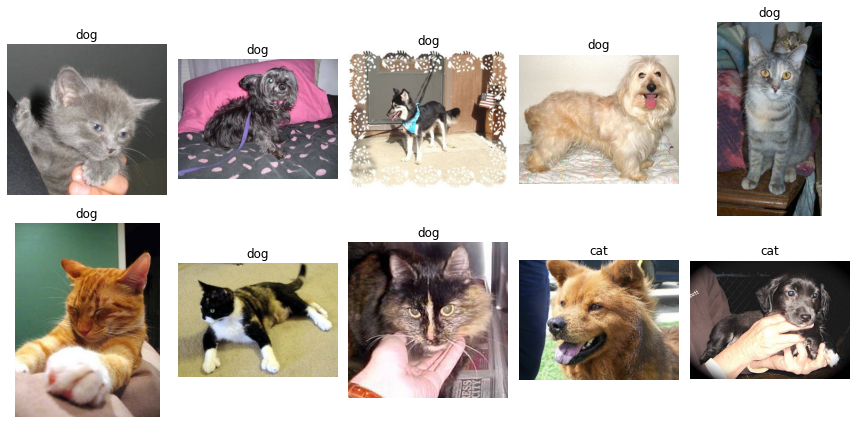

In [ ]:
display_test_image_grid(test_images_filepaths)

# 예측력이 좋지는 않다. 데이터셋이 너무 작기 때문이다.
# 실무에서는 직접 모델을 구축하는 대신 pre-trained model을 사용하기 때문에 실제로 이처럼 하지는 않는다.
